# Baseball Testing

In [2]:
import pandas as pd
import numpy as np
import requests
from rpy2.robjects import r, pandas2ri
import pyreadr
import matplotlib.pyplot as plt
from pandasql import sqldf
from bs4 import BeautifulSoup
import requests
from html_table_parser import HTMLTableParser
from selenium import webdriver
import time
from baseball_scraper import playerid_lookup
from unidecode import unidecode
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Setting up function for loading Rdata into python from Github Source

def git_load(Name):
    github_url = f'https://github.com/cdalzell/Lahman/raw/master/data/{Name}.RData'

    # Download the RData file
    response = requests.get(github_url)
    
    with open(f'{Name}.RData', 'wb') as f:
        f.write(response.content)
    
    result = pyreadr.read_r(f'{Name}.RData')
    print(result.keys())
    
    globals()[f'{Name}_df'] = result[f'{Name}']

In [4]:
# Calling all Tables from Github
table_names = ['People','Pitching', 'AwardsPlayers', 'AwardsSharePlayers', 'PitchingPost', 'Salaries', 'AllstarFull', 'SeriesPost', 'HallOfFame']
table_names

for x in table_names:
    git_load(x)

odict_keys(['People'])
odict_keys(['Pitching'])
odict_keys(['AwardsPlayers'])
odict_keys(['AwardsSharePlayers'])
odict_keys(['PitchingPost'])
odict_keys(['Salaries'])
odict_keys(['AllstarFull'])
odict_keys(['SeriesPost'])
odict_keys(['HallOfFame'])


## People dataframe

In [5]:
# People_df Exploration
People_df.info()
# print(People_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20676 entries, 0 to 20675
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   playerID      20676 non-null  object  
 1   birthYear     20567 non-null  object  
 2   birthMonth    20398 non-null  object  
 3   birthDay      20256 non-null  object  
 4   birthCountry  20617 non-null  object  
 5   birthState    20136 non-null  object  
 6   birthCity     20508 non-null  object  
 7   deathYear     10098 non-null  object  
 8   deathMonth    10097 non-null  object  
 9   deathDay      10096 non-null  object  
 10  deathCountry  10094 non-null  object  
 11  deathState    10038 non-null  object  
 12  deathCity     10089 non-null  object  
 13  nameFirst     20639 non-null  object  
 14  nameLast      20676 non-null  object  
 15  nameGiven     20639 non-null  object  
 16  weight        19864 non-null  object  
 17  height        19944 non-null  object  
 18  bats  

## Pitching Dataframe

In [6]:
# Pitching_df Exploration
Pitching_df.info()
#print(Pitching_df.describe())
#Pitching_df['yearID'] = pd.to_datetime(df['yearID'], format = '%Y')
Pitching_df.groupby('ERA')['yearID'].min()
Pitching_df[Pitching_df['ERA'].notnull()]['yearID'].min()
#Pitching_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50402 entries, 0 to 50401
Data columns (total 30 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   playerID  50402 non-null  object  
 1   yearID    50402 non-null  int32   
 2   stint     50402 non-null  int32   
 3   teamID    50402 non-null  category
 4   lgID      50402 non-null  category
 5   W         50402 non-null  int32   
 6   L         50402 non-null  int32   
 7   G         50402 non-null  int32   
 8   GS        50402 non-null  int32   
 9   CG        50402 non-null  int32   
 10  SHO       50402 non-null  int32   
 11  SV        50402 non-null  int32   
 12  IPouts    50402 non-null  int32   
 13  H         50402 non-null  int32   
 14  ER        50402 non-null  int32   
 15  HR        50402 non-null  int32   
 16  BB        50402 non-null  int32   
 17  SO        50402 non-null  int32   
 18  BAOpp     45958 non-null  float64 
 19  ERA       50305 non-null  float64 
 20  IBB   

1871

In [7]:
print(Pitching_df[Pitching_df['IBB'].notnull()]['yearID'].min())
print(Pitching_df[Pitching_df['yearID'] == 1955].iloc[0])

1955
playerID    aberal01
yearID          1955
stint              1
teamID           DET
lgID              AL
W                  6
L                  3
G                 39
GS                 1
CG                 0
SHO                0
SV                 3
IPouts           240
H                 86
ER                30
HR                 9
BB                28
SO                37
BAOpp           0.27
ERA             3.38
IBB                1
WP                 1
HBP                0
BK                 0
BFP              346
GF                22
R                 32
SH               NaN
SF               NaN
GIDP             NaN
Name: 14578, dtype: object


In [8]:
# joining debut into pitching df and then modifying the debut column
q = '''
SELECT
a.*,
b.debut
FROM
    Pitching_df a
LEFT JOIN
    People_df b
        on a.playerID = b.playerID
;
'''
Pitching_debut_df = sqldf(q, locals())
Pitching_debut_df['debut'] = Pitching_debut_df['debut'].astype(str).str[:4]
Pitching_debut_df.loc[Pitching_debut_df['debut'] == 'None']
Pitching_debut_df.replace('None', None, inplace = True)
Pitching_debut_df['debut'] = Pitching_debut_df['debut'].astype(np.int64)

In [9]:
# keeping all pitchers who have a debut date of greater than 1955
Pitching_1955 = Pitching_debut_df.loc[Pitching_debut_df['debut'] >= 1955]
Pitching_1955 = Pitching_1955.drop(columns=['SH', 'SF', 'GIDP', 'debut'])
len(Pitching_1955)

34532

In [10]:
# Grouping all the players together by sum or avg in my population
q = '''
SELECT
    playerID,
    sum(W) as W_tot,
    sum(L) as L_tot,
    sum(G) as G_tot,
    sum(GS) as GS_tot,
    sum(CG) as CG_tot,
    sum(SHO) as SHO_tot,
    sum(SV) as SV_tot,
    sum(IPouts) as IPouts_tot,
    sum(H) as H_tot,
    sum(ER) as ER_tot,
    sum(HR) as HR_tot,
    sum(BB) as BB_tot,
    sum(SO) as SO_tot,
    avg(BAOpp) as BAOpp_avg,
    avg(ERA) as ERA_avg,
    sum(IBB) as IBB_tot,
    sum(WP) as WP_tot,
    sum(HBP) as HBP_tot,
    sum(BK) as BK_tot,
    sum(BFP) as BFP_tot,
    sum(GF) as GF_tot,
    sum(R) as R_tot
FROM
    Pitching_1955
GROUP BY playerID
;
'''
Pitching_1955_player_career = sqldf(q, locals())
Pitching_1955_player_career

,playerID,W_tot,L_tot,G_tot,GS_tot,CG_tot,SHO_tot,SV_tot,IPouts_tot,H_tot,...,SO_tot,BAOpp_avg,ERA_avg,IBB_tot,WP_tot,HBP_tot,BK_tot,BFP_tot,GF_tot,R_tot
0,aardsda01,16,18,331,0,0,0,69,1011,296,...,340,0.257444,5.194444,22.0,12,16.0,1,1475.0,141,169
1,aasedo01,66,60,448,91,22,5,82,3328,1085,...,641,0.250846,3.493077,45.0,22,7.0,3,4730.0,235,503
2,abadfe01,8,29,400,6,0,0,2,1045,332,...,290,0.250364,4.219091,11.0,10,12.0,2,1481.0,101,155
3,abbotco01,0,5,23,10,0,0,0,196,64,...,57,0.262500,6.000000,0.0,4,5.0,0,298.0,9,45
4,abbotgl01,62,83,248,206,37,5,0,3858,1405,...,484,0.278583,4.331667,28.0,18,32.0,5,5508.0,13,707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6501,zitoba01,165,143,433,421,12,5,0,7730,2381,...,1885,0.256067,4.556000,52.0,50,97.0,8,11001.0,9,1254
6502,zobribe01,0,0,1,0,0,0,0,3,0,...,1,0.000000,0.000000,0.0,0,0.0,0,5.0,1,0
6503,zuberty01,1,5,54,0,0,0,0,148,41,...,55,0.223500,5.175000,2.0,3,2.0,0,222.0,14,31
6504,zumayjo01,13,12,171,0,0,0,5,629,169,...,210,0.228600,3.442000,11.0,16,4.0,0,911.0,35,80


In [11]:
# looking at info
Pitching_1955_player_career.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6506 entries, 0 to 6505
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   playerID    6506 non-null   object 
 1   W_tot       6506 non-null   int64  
 2   L_tot       6506 non-null   int64  
 3   G_tot       6506 non-null   int64  
 4   GS_tot      6506 non-null   int64  
 5   CG_tot      6506 non-null   int64  
 6   SHO_tot     6506 non-null   int64  
 7   SV_tot      6506 non-null   int64  
 8   IPouts_tot  6506 non-null   int64  
 9   H_tot       6506 non-null   int64  
 10  ER_tot      6506 non-null   int64  
 11  HR_tot      6506 non-null   int64  
 12  BB_tot      6506 non-null   int64  
 13  SO_tot      6506 non-null   int64  
 14  BAOpp_avg   6505 non-null   float64
 15  ERA_avg     6501 non-null   float64
 16  IBB_tot     6506 non-null   float64
 17  WP_tot      6506 non-null   int64  
 18  HBP_tot     6506 non-null   float64
 19  BK_tot      6506 non-null  

In [12]:
# dropping 5 players due to them not having ERA and BAopp due to limited pitching in MLB.
drop_players = Pitching_1955_player_career['playerID'].loc[Pitching_1955_player_career['ERA_avg'].isnull()].tolist()
print(drop_players)
Pitching_1955_player_career = Pitching_1955_player_career[~Pitching_1955_player_career.playerID.isin(drop_players)]
Pitching_1955_player_career.info()

['bruckfr01', 'davalvi01', 'parrage01', 'sundigo01', 'yountla01']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6501 entries, 0 to 6505
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   playerID    6501 non-null   object 
 1   W_tot       6501 non-null   int64  
 2   L_tot       6501 non-null   int64  
 3   G_tot       6501 non-null   int64  
 4   GS_tot      6501 non-null   int64  
 5   CG_tot      6501 non-null   int64  
 6   SHO_tot     6501 non-null   int64  
 7   SV_tot      6501 non-null   int64  
 8   IPouts_tot  6501 non-null   int64  
 9   H_tot       6501 non-null   int64  
 10  ER_tot      6501 non-null   int64  
 11  HR_tot      6501 non-null   int64  
 12  BB_tot      6501 non-null   int64  
 13  SO_tot      6501 non-null   int64  
 14  BAOpp_avg   6501 non-null   float64
 15  ERA_avg     6501 non-null   float64
 16  IBB_tot     6501 non-null   float64
 17  WP_tot      6501 non-null   int64  
 18  HB

In [13]:
# table to be used in analysis and modeling
Pitching_1955_player_career

,playerID,W_tot,L_tot,G_tot,GS_tot,CG_tot,SHO_tot,SV_tot,IPouts_tot,H_tot,...,SO_tot,BAOpp_avg,ERA_avg,IBB_tot,WP_tot,HBP_tot,BK_tot,BFP_tot,GF_tot,R_tot
0,aardsda01,16,18,331,0,0,0,69,1011,296,...,340,0.257444,5.194444,22.0,12,16.0,1,1475.0,141,169
1,aasedo01,66,60,448,91,22,5,82,3328,1085,...,641,0.250846,3.493077,45.0,22,7.0,3,4730.0,235,503
2,abadfe01,8,29,400,6,0,0,2,1045,332,...,290,0.250364,4.219091,11.0,10,12.0,2,1481.0,101,155
3,abbotco01,0,5,23,10,0,0,0,196,64,...,57,0.262500,6.000000,0.0,4,5.0,0,298.0,9,45
4,abbotgl01,62,83,248,206,37,5,0,3858,1405,...,484,0.278583,4.331667,28.0,18,32.0,5,5508.0,13,707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6501,zitoba01,165,143,433,421,12,5,0,7730,2381,...,1885,0.256067,4.556000,52.0,50,97.0,8,11001.0,9,1254
6502,zobribe01,0,0,1,0,0,0,0,3,0,...,1,0.000000,0.000000,0.0,0,0.0,0,5.0,1,0
6503,zuberty01,1,5,54,0,0,0,0,148,41,...,55,0.223500,5.175000,2.0,3,2.0,0,222.0,14,31
6504,zumayjo01,13,12,171,0,0,0,5,629,169,...,210,0.228600,3.442000,11.0,16,4.0,0,911.0,35,80


## Awards Players Dataframe

In [14]:
# AwardsPlayers_df Exploration
AwardsPlayers_df.info()
print(AwardsPlayers_df.describe())
AwardsPlayers_df.loc[~AwardsPlayers_df["tie"].isna()]
AwardsPlayers_df["awardID"].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6531 entries, 0 to 6530
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   playerID  6531 non-null   object  
 1   awardID   6531 non-null   object  
 2   yearID    6531 non-null   int32   
 3   lgID      6527 non-null   category
 4   tie       53 non-null     object  
 5   notes     4999 non-null   object  
dtypes: category(1), int32(1), object(4)
memory usage: 236.3+ KB
            yearID
count  6531.000000
mean   1971.924208
std      32.107723
min    1877.000000
25%    1944.000000
50%    1978.000000
75%    1999.000000
max    2021.000000


array(['Pitching Triple Crown', 'Triple Crown',
       'Baseball Magazine All-Star', 'Most Valuable Player',
       'TSN All-Star', 'TSN Guide MVP',
       'TSN Major League Player of the Year', 'TSN Pitcher of the Year',
       'TSN Player of the Year', 'Rookie of the Year', 'Babe Ruth Award',
       'Lou Gehrig Memorial Award', 'World Series MVP', 'Cy Young Award',
       'Gold Glove', 'TSN Fireman of the Year', 'All-Star Game MVP',
       'Hutch Award', 'Roberto Clemente Award',
       'Rolaids Relief Man Award', 'NLCS MVP', 'ALCS MVP',
       'Silver Slugger', 'Branch Rickey Award', 'Hank Aaron Award',
       'TSN Reliever of the Year', 'Comeback Player of the Year',
       'Outstanding DH Award', 'Reliever of the Year Award',
       'SIlver Slugger'], dtype=object)

In [15]:
# Setting up from population of players those who had awards and only keeping those awards that contribute to a players career without being repetitive (limiting amount of awards).
q = '''
SELECT 
a.playerID,
count(*) as award_count
FROM 
    AwardsPlayers_df a
INNER JOIN
    Pitching_1955_player_career b
        on a.playerID = b.playerID
Where awardID in (
                    'Pitching Triple Crown',
                    'Triple Crown',
                    'Most Valuable Player',
                    'Rookie of the Year',
                    'Babe Ruth Award',
                    'World Series MVP',
                    'Cy Young Award',
                    'Gold Glove',
                    'All-Star Game MVP',
                    'Roberto Clemente Award',
                    'Rolaids Relief Man Award',
                    'NLCS MVP',
                    'ALCS MVP',
                    'Silver Slugger',
                    'Hank Aaron Award',
                    'Comeback Player of the Year',
                    'Outstanding DH Award',
                    'Reliever of the Year Award',
                    'SIlver Slugger'
                )
GROUP BY
a.playerID
;
'''

Pitching_1955_awards = sqldf(q, locals())
# table to be used in analysis and modeling
Pitching_1955_awards

,playerID,award_count
0,alfonan01,1
1,andujjo01,1
2,arrieja01,2
3,arroybr01,1
4,averyst01,1
...,...,...
277,youngch03,1
278,zachrpa01,1
279,zambrca01,3
280,zitoba01,1


## Awards Share Players Dataframe

In [16]:
# AwardsSharePlayers_df Exploration
# AwardsSharePlayers_df.info()
print(AwardsSharePlayers_df.describe())
print(AwardsSharePlayers_df['awardID'].unique())
AwardsSharePlayers_df.loc[AwardsSharePlayers_df['awardID'] == 'Cy Young']

            yearID    pointsWon    pointsMax   votesFirst
count  6879.000000  6879.000000  6879.000000  6521.000000
mean   1972.461259    43.559674   267.518389     1.624751
std      27.707848    68.265957   128.988138     4.911428
min    1911.000000     0.000000    16.000000     0.000000
25%    1950.000000     4.000000   140.000000     0.000000
50%    1975.000000    12.000000   336.000000     0.000000
75%    1996.000000    53.000000   336.000000     0.000000
max    2016.000000   448.000000   448.000000    32.000000
['Cy Young' 'MVP' 'Rookie of the Year']


,awardID,yearID,lgID,playerID,pointsWon,pointsMax,votesFirst
0,Cy Young,1956,ML,fordwh01,1.0,16,1.0
1,Cy Young,1956,ML,maglisa01,4.0,16,4.0
2,Cy Young,1956,ML,newcodo01,10.0,16,10.0
3,Cy Young,1956,ML,spahnwa01,1.0,16,1.0
4,Cy Young,1957,ML,donovdi01,1.0,16,1.0
...,...,...,...,...,...,...,...
6859,Cy Young,2016,NL,cuetojo01,19.0,210,0.0
6860,Cy Young,2016,NL,fernajo02,18.0,210,0.0
6861,Cy Young,2016,NL,syndeno01,15.0,210,0.0
6862,Cy Young,2016,NL,arrieja01,2.0,210,0.0


In [17]:
# soup = BeautifulSoup(requests.get(f'https://www.baseball-reference.com/awards/awards_2021.shtml').text.replace('<!--','').replace('-->',''))
# soup#.find_all('data-append-csv')



# id_value = soup.find('td', {'data-append-csv': True})['data-append-csv']
# id_value

# mvp_table_headers = table.find_all('th')
# mvp_table_headers

# TAKING TEXT FROM EACH OF THESE LOOPING GETTING ALL HEADER NAMES FROM THE TABLE
# mvp_table_headers = [title.text for title in mvp_table_headers]
#print(mvp_table_headers) # need to clean up
# mvp_table_headers = mvp_table_headers[6:36]
# df = pd.DataFrame(columns = mvp_table_headers)

# column_data = table.find_all('tr')
# table.find_all('tr')[2]

# for row in column_data[2:]: # starting at position one
#     row_data = row.find_all('td')
#     individual_row_data = [data.text.strip() for data in row_data]
#     length = len(df)
#     df.loc[length] = individual_row_data 
# row_data

In [18]:
# Web Scraping to get mvp, CY Young, and ROY results and votes for seasons after 2016
seasons = ['2017', '2018', '2019', '2020', '2021', '2022']
mvp_tables = [0,1]
cy_tables = [2,3]
roy_tables = [4,5]



for x in seasons:
    soup = BeautifulSoup(
            requests.get(f'https://www.baseball-reference.com/awards/awards_{x}.shtml').text.replace('<!--','').replace('-->','')
    ) # some tables are hidden in comments
    
    for y in mvp_tables:
        table = soup.find_all('table')[y]

        mvp_table_headers = table.find_all('th')
        mvp_table_headers

        # TAKING TEXT FROM EACH OF THESE LOOPING GETTING ALL HEADER NAMES FROM THE TABLE
        mvp_table_headers = [title.text for title in mvp_table_headers]
        #print(mvp_table_headers) # need to clean up
        mvp_table_headers = mvp_table_headers[6:36]
        df = pd.DataFrame(columns = mvp_table_headers)
        column_data = table.find_all('tr')
        # table.find_all('tr')[2]
        ids = []
        
        for row in column_data[2:]: # starting at position one
            row_data = row.find_all('td')
            id_value = row.find('td', {'data-append-csv': True})['data-append-csv']
            ids.append(id_value)
            individual_row_data = [data.text.strip() for data in row_data]
            length = len(df)
            df.loc[length] = individual_row_data 

        # removing the \n in the 10th column name
        df.columns = [c.replace("\n", "") for c in df.columns]
        df['playerID'] = ids
        globals()[f'mvp_{y}_{x}'] = df
        print(f'mvp_{y}_{x}')
        
    for y in cy_tables:
        table = soup.find_all('table')[y]

        cy_table_headers = table.find_all('th')
        cy_table_headers

        # TAKING TEXT FROM EACH OF THESE LOOPING GETTING ALL HEADER NAMES FROM THE TABLE
        cy_table_headers = [title.text for title in cy_table_headers]
        #print(cy_table_headers) # need to clean up
        cy_table_headers = cy_table_headers[1:31]
        df = pd.DataFrame(columns = cy_table_headers)

        column_data = table.find_all('tr')
        column_data[1]
        ids = []

        for row in column_data[1:]: # starting at position one
            row_data = row.find_all('td')
            id_value = row.find('td', {'data-append-csv': True})['data-append-csv']
            ids.append(id_value)
            individual_row_data = [data.text.strip() for data in row_data]
            length = len(df)
            df.loc[length] = individual_row_data 
        df['playerID'] = ids
        globals()[f'cy_{y}_{x}'] = df
        print(f'cy_{y}_{x}')
    
    for y in roy_tables:
        table = soup.find_all('table')[y]

        roy_table_headers = table.find_all('th')
        roy_table_headers

        # TAKING TEXT FROM EACH OF THESE LOOPING GETTING ALL HEADER NAMES FROM THE TABLE
        roy_table_headers = [title.text for title in roy_table_headers]
        #print(roy_table_headers) # need to clean up
        roy_table_headers = roy_table_headers[6:36]
        df = pd.DataFrame(columns = roy_table_headers)
        df

        column_data = table.find_all('tr')
        column_data[1]
        ids = []

        for row in column_data[2:]: # starting at position one
            row_data = row.find_all('td')
            id_value = row.find('td', {'data-append-csv': True})['data-append-csv']
            ids.append(id_value)
            individual_row_data = [data.text.strip() for data in row_data]
            length = len(df)
            df.loc[length] = individual_row_data 
        df['playerID'] = ids
        globals()[f'roy_{y}_{x}'] = df
        print(f'roy_{y}_{x}')


mvp_0_2017
mvp_1_2017
cy_2_2017
cy_3_2017
roy_4_2017
roy_5_2017
mvp_0_2018
mvp_1_2018
cy_2_2018
cy_3_2018
roy_4_2018
roy_5_2018
mvp_0_2019
mvp_1_2019
cy_2_2019
cy_3_2019
roy_4_2019
roy_5_2019
mvp_0_2020
mvp_1_2020
cy_2_2020
cy_3_2020
roy_4_2020
roy_5_2020
mvp_0_2021
mvp_1_2021
cy_2_2021
cy_3_2021
roy_4_2021
roy_5_2021
mvp_0_2022
mvp_1_2022
cy_2_2022
cy_3_2022
roy_4_2022
roy_5_2022


In [19]:
# Concating mvp tables

NL_mvp_tables = [1]
for y in seasons:
    for x in NL_mvp_tables:
        locals().get(f"mvp_{x}_{y}")['lgID'] = 'NL' 
        
AL_mvp_tables = [0]
for y in seasons:
    for x in AL_mvp_tables:
        locals().get(f"mvp_{x}_{y}")['lgID'] = 'AL' 

for y in seasons:
    for x in mvp_tables:
        locals().get(f"mvp_{x}_{y}")['yearID'] = f'{y}' 
#         current_df = locals().get(f"mvp_{x}_{y}")
#         mvp_award_shares = mvp_award_shares.union(current_df)



mvp_award_shares = pd.concat([mvp_0_2017,
                                  mvp_1_2017, 
                                  mvp_0_2018, 
                                  mvp_1_2018,
                                  mvp_0_2019,
                                  mvp_1_2019,
                                  mvp_0_2020,
                                  mvp_1_2020,
                                  mvp_0_2021,
                                  mvp_1_2021,
                                  mvp_0_2022,
                                  mvp_1_2022,
                                 ])

mvp_award_shares['pointsMax'] = 420
mvp_award_shares['awardID'] = "MVP"
mvp_award_shares.drop(mvp_award_shares.iloc[:, 4:30].columns, axis=1, inplace= True)
#mvp_award_shares.info()
mvp_award_shares.rename(columns={'Vote Pts':'pointsWon', '1st Place':'votesFirst'}, inplace=True)
mvp_award_shares = mvp_award_shares[['awardID', 'yearID', 'lgID', 'playerID', 'pointsWon', 'pointsMax', 'votesFirst']]
#mvp_award_shares


In [20]:
# Concating mvp tables

NL_cy_tables = [3]
for y in seasons:
    for x in NL_cy_tables:
        locals().get(f"cy_{x}_{y}")['lgID'] = 'NL' 
        
AL_cy_tables = [2]
for y in seasons:
    for x in AL_cy_tables:
        locals().get(f"cy_{x}_{y}")['lgID'] = 'AL' 

for y in seasons:
    for x in cy_tables:
        locals().get(f"cy_{x}_{y}")['yearID'] = f'{y}' 
#         current_df = locals().get(f"cy_{x}_{y}")
#         cy_award_shares = cy_award_shares.union(current_df)



cy_award_shares = pd.concat([cy_2_2017,
                                  cy_3_2017, 
                                  cy_2_2018, 
                                  cy_3_2018,
                                  cy_2_2019,
                                  cy_3_2019,
                                  cy_2_2020,
                                  cy_3_2020,
                                  cy_2_2021,
                                  cy_3_2021,
                                  cy_2_2022,
                                  cy_3_2022,
                                 ])

cy_award_shares['pointsMax'] = 210
cy_award_shares['awardID'] = "Cy Young"
cy_award_shares.drop(cy_award_shares.iloc[:, 4:30].columns, axis=1, inplace= True)
#cy_award_shares.info()
cy_award_shares.rename(columns={'Vote Pts':'pointsWon', '1st Place':'votesFirst'}, inplace=True)
cy_award_shares = cy_award_shares[['awardID', 'yearID', 'lgID', 'playerID', 'pointsWon', 'pointsMax', 'votesFirst']]
#cy_award_shares


In [21]:
# Concating Roy tables

NL_roy_tables = [5]
for y in seasons:
    for x in NL_roy_tables:
        locals().get(f"roy_{x}_{y}")['lgID'] = 'NL' 
        
AL_roy_tables = [4]
for y in seasons:
    for x in AL_roy_tables:
        locals().get(f"roy_{x}_{y}")['lgID'] = 'AL' 

for y in seasons:
    for x in roy_tables:
        locals().get(f"roy_{x}_{y}")['yearID'] = f'{y}' 
#         current_df = locals().get(f"roy_{x}_{y}")
#         roy_award_shares = roy_award_shares.union(current_df)



roy_award_shares = pd.concat([roy_5_2017,
                                  roy_4_2017, 
                                  roy_5_2018, 
                                  roy_4_2018,
                                  roy_5_2019,
                                  roy_4_2019,
                                  roy_5_2020,
                                  roy_4_2020,
                                  roy_5_2021,
                                  roy_4_2021,
                                  roy_5_2022,
                                  roy_4_2022,
                                 ])

roy_award_shares['pointsMax'] = 420
roy_award_shares['awardID'] = "Rookie of the Year"
roy_award_shares.drop(roy_award_shares.iloc[:, 4:30].columns, axis=1, inplace= True)
#roy_award_shares.info()
roy_award_shares.rename(columns={'Vote Pts':'pointsWon', '1st Place':'votesFirst'}, inplace=True)
roy_award_shares = roy_award_shares[['awardID', 'yearID', 'lgID', 'playerID', 'pointsWon', 'pointsMax', 'votesFirst']]
#roy_award_shares


In [22]:
# Concating all tables
combined_award_shares = pd.concat([mvp_award_shares,cy_award_shares,roy_award_shares])
combined_award_shares

# And finally Concating to main AwardsSharePlayers_df
AwardsSharePlayers_df = pd.concat([AwardsSharePlayers_df, combined_award_shares])
AwardsSharePlayers_df[['yearID', 'pointsWon', 'votesFirst']] = AwardsSharePlayers_df[['yearID', 'pointsWon', 'votesFirst']].apply(pd.to_numeric)
print(AwardsSharePlayers_df.dtypes)
len(AwardsSharePlayers_df)
AwardsSharePlayers_df

awardID        object
yearID          int64
lgID           object
playerID       object
pointsWon     float64
pointsMax       int64
votesFirst    float64
dtype: object


,awardID,yearID,lgID,playerID,pointsWon,pointsMax,votesFirst
0,Cy Young,1956,ML,fordwh01,1.0,16,1.0
1,Cy Young,1956,ML,maglisa01,4.0,16,4.0
2,Cy Young,1956,ML,newcodo01,10.0,16,10.0
3,Cy Young,1956,ML,spahnwa01,1.0,16,1.0
4,Cy Young,1957,ML,donovdi01,1.0,16,1.0
...,...,...,...,...,...,...,...
1,Rookie of the Year,2022,AL,rutscad01,68.0,420,1.0
2,Rookie of the Year,2022,AL,kwanst01,44.0,420,0.0
3,Rookie of the Year,2022,AL,wittbo02,7.0,420,0.0
4,Rookie of the Year,2022,AL,penaje02,2.0,420,0.0


In [23]:
q = '''
SELECT 
a.awardID,
a.playerID,
sum(a.pointsWon) as pointsWon_tot
FROM 
    AwardsSharePlayers_df a
INNER JOIN
    Pitching_1955_player_career b
        on a.playerID = b.playerID
GROUP BY
a.awardID,
a.playerID
;
'''
AwardsSharePlayers_career_df = sqldf(q, locals())
AwardsSharePlayers_career_df

,awardID,playerID,pointsWon_tot
0,Cy Young,abbotji01,26.0
1,Cy Young,alcansa01,210.0
2,Cy Young,alexado01,13.0
3,Cy Young,alvarhe01,1.0
4,Cy Young,andujjo01,19.0
...,...,...,...
1223,Rookie of the Year,zachrpa01,11.0
1224,Rookie of the Year,zeileto01,4.0
1225,Rookie of the Year,zieglbr01,1.0
1226,Rookie of the Year,zimmeje02,27.0


In [24]:
# pivoting the AwardsSharePlayers_career_df table
AwardsSharePlayers_career_df_pivot = AwardsSharePlayers_career_df.pivot(index= 'playerID', columns= 'awardID', values= 'pointsWon_tot')
AwardsSharePlayers_career_df_pivot.reset_index(inplace=True)
AwardsSharePlayers_career_df_pivot = AwardsSharePlayers_career_df_pivot.rename_axis(None, axis=1)
AwardsSharePlayers_career_df_pivot.fillna(0, inplace=True)
# table to be used in analysis and modeling
AwardsSharePlayers_career_df_pivot = AwardsSharePlayers_career_df_pivot.rename(columns={'Cy Young': 'CYY_totvotes', 'MVP': 'MVP_totvotes', 'Rookie of the Year':'ROY_totvotes'})
AwardsSharePlayers_career_df_pivot

,playerID,CYY_totvotes,MVP_totvotes,ROY_totvotes
0,abbotji01,26.0,0.0,10.0
1,abernte02,0.0,8.0,0.0
2,affelje01,0.0,1.0,0.0
3,aguilri01,0.0,11.0,0.0
4,aguirha01,0.0,10.0,0.0
...,...,...,...,...
801,zieglbr01,0.0,0.0,1.0
802,zimmeje02,0.0,0.0,27.0
803,zimmejo02,46.0,0.0,0.0
804,zitoba01,114.0,24.0,1.0


## Pitching Post Dataframe

In [25]:
# PitchingPost_df Exploration
#PitchingPost_df.info()
PitchingPost_df.describe()
#PitchingPost_df

,yearID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,GF,R
count,6538.000000,6538.000000,6538.000000,6538.000000,6538.000000,6538.000000,6538.000000,6538.000000,6538.000000,6538.000000,6538.000000,6538.000000,6538.000000,6538.000000,6466.000000,6503.00,6538.000000,6538.000000
mean,1994.493423,0.275925,0.275925,1.910370,0.553686,0.101101,0.021872,0.105231,14.865402,4.481646,1.968492,0.495106,1.765831,3.798868,0.246959,inf,0.452585,2.225757
std,27.699529,0.536025,0.512984,1.015821,0.779072,0.428839,0.153423,0.409016,14.331376,4.483824,2.258413,0.794499,1.947313,3.801212,0.167579,NaN,0.815165,2.636013
min,1884.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
25%,1984.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.146000,0.00,0.000000,0.000000
50%,2003.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,11.000000,3.000000,1.000000,0.000000,1.000000,3.000000,0.235000,2.70,0.000000,1.000000
75%,2014.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,19.000000,6.000000,3.000000,1.000000,3.000000,5.000000,0.333000,6.35,1.000000,3.000000
max,2022.000000,4.000000,4.000000,8.000000,8.000000,8.000000,3.000000,4.000000,213.000000,64.000000,26.000000,5.000000,32.000000,35.000000,1.000000,inf,6.000000,36.000000


In [26]:
# Setting up from population of players those who had postseason appearances
q = '''
SELECT 
a.*
FROM 
    PitchingPost_df a
INNER JOIN
    Pitching_1955_player_career b
        on a.playerID = b.playerID
;
'''
Pitching_1955_post_player = sqldf(q, locals())

# dropping players who had null ERA or BAOpp due to limited innings pitched
drop_players = Pitching_1955_post_player['playerID'].loc[Pitching_1955_post_player['ERA'].isnull() | Pitching_1955_post_player['BAOpp'].isnull()].tolist()
# drop_players[['playerID','ERA', 'BAOpp']]
print(drop_players)
Pitching_1955_post_player = Pitching_1955_post_player[~Pitching_1955_post_player.playerID.isin(drop_players)]
# Pitching_1955_post_player.info()

['richepe01', 'hamilda01', 'zachach02', 'watted01', 'poledi01', 'roberda05', 'agostju01', 'lavelga01', 'klinkjo01', 'vosbeed01', 'mormaal01', 'milletr02', 'reedst01', 'chrisja01', 'nelsoje01', 'klinest02', 'marteda01', 'myersmi01', 'eyresc01', 'fultzaa01', 'lopezja02', 'speiery01', 'milletr02', 'bastaan01', 'marteda01', 'durbich01', 'howeljp01', 'mcgeeja01', 'durbich01', 'porceri01', 'porceri01', 'freemsa01', 'hammeja01', 'delarjo01', 'martich02', 'garream01', 'fairbpe01']


In [27]:
# Grouping all the postseason players together by sum or avg in my population
q = '''
SELECT
playerID,
    sum(W) as W_post_tot,
    sum(L) as L_post_tot,
    sum(G) as G_post_tot,
    sum(GS) as GS_post_tot,
    sum(CG) as CG_post_tot,
    sum(SHO) as SHO_post_tot,
    sum(SV) as SV_post_tot,
    sum(IPouts) as IPouts_post_tot,
    sum(H) as H_post_tot,
    sum(ER) as ER_post_tot,
    sum(HR) as HR_post_tot,
    sum(BB) as BB_post_tot,
    sum(SO) as SO_post_tot,
    avg(BAOpp) as BAOpp_post_avg,
    avg(ERA) as ERA_post_avg,
    sum(IBB) as IBB_post_tot,
    sum(WP) as QP_post_tot,
    sum(HBP) as HBP_post_tot,
    sum(BK) as BK_post_tot,
    sum(BFP) as BFP_post_tot,
    sum(GF) as GF_post_tot,
    sum(R) as R_post_tot
FROM
    Pitching_1955_post_player
GROUP BY playerID
;
'''

Pitching_1955_post_player_career = sqldf(q, locals())
# table to be used in analysis and modeling
Pitching_1955_post_player_career
Pitching_1955_post_player_career.columns.tolist()

['playerID',
 'W_post_tot',
 'L_post_tot',
 'G_post_tot',
 'GS_post_tot',
 'CG_post_tot',
 'SHO_post_tot',
 'SV_post_tot',
 'IPouts_post_tot',
 'H_post_tot',
 'ER_post_tot',
 'HR_post_tot',
 'BB_post_tot',
 'SO_post_tot',
 'BAOpp_post_avg',
 'ERA_post_avg',
 'IBB_post_tot',
 'QP_post_tot',
 'HBP_post_tot',
 'BK_post_tot',
 'BFP_post_tot',
 'GF_post_tot',
 'R_post_tot']

## Allstar Dataframe

In [28]:
# AllstarFull_df Exploration
AllstarFull_df.info()
print(AllstarFull_df.describe())
AllstarFull_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5516 entries, 0 to 5515
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   playerID     5516 non-null   object  
 1   yearID       5516 non-null   int32   
 2   gameNum      5516 non-null   int32   
 3   gameID       5467 non-null   object  
 4   teamID       5516 non-null   category
 5   lgID         5516 non-null   category
 6   GP           5516 non-null   int32   
 7   startingPos  1731 non-null   object  
dtypes: category(2), int32(3), object(3)
memory usage: 206.3+ KB
            yearID      gameNum           GP
count  5516.000000  5516.000000  5516.000000
mean   1979.730421     0.094996     0.782088
std      25.462361     0.389393     0.412864
min    1933.000000     0.000000     0.000000
25%    1959.000000     0.000000     1.000000
50%    1980.000000     0.000000     1.000000
75%    2003.000000     0.000000     1.000000
max    2022.000000     2.000000     1.0

,playerID,yearID,gameNum,gameID,teamID,lgID,GP,startingPos
0,gomezle01,1933,0,ALS193307060,NYA,AL,1,1
1,ferreri01,1933,0,ALS193307060,BOS,AL,1,2
2,gehrilo01,1933,0,ALS193307060,NYA,AL,1,3
3,gehrich01,1933,0,ALS193307060,DET,AL,1,4
4,dykesji01,1933,0,ALS193307060,CHA,AL,1,5
...,...,...,...,...,...,...,...,...
5511,rileyau01,2022,0,NLS202207190,ATL,NL,1,NaN
5512,schwaky01,2022,0,NLS202207190,PHI,NL,1,NaN
5513,sotoju01,2022,0,NLS202207190,WAS,NL,1,NaN
5514,swansda01,2022,0,NLS202207190,ATL,NL,1,NaN


In [29]:
# Allstar Data prep

q = '''
SELECT
a.playerID,
count(*) as allstar_tot
FROM
    AllstarFull_df a
INNER JOIN     
    Pitching_1955_player_career b
        on a.playerID = b.playerID
GROUP BY
a.playerID
;
'''

AllstarFull_player_career = sqldf(q, locals())
# table to be used in analysis and modeling
AllstarFull_player_career

,playerID,allstar_tot
0,aasedo01,1
1,aguilri01,3
2,aguirha01,1
3,alcansa01,2
4,alexado01,1
...,...,...
712,zambrca01,3
713,zimmeje02,1
714,zimmejo02,2
715,zitoba01,3


## Hall of Fame Dataframe

In [30]:
# HallOfFame_df Exploration
HallOfFame_df.info()
print(HallOfFame_df.describe())
# table to be used in analysis and modeling
HallOfFame_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4323 entries, 0 to 4322
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   playerID     4323 non-null   object  
 1   yearID       4323 non-null   int32   
 2   votedBy      4323 non-null   object  
 3   ballots      4116 non-null   float64 
 4   needed       3959 non-null   float64 
 5   votes        4116 non-null   float64 
 6   inducted     4323 non-null   category
 7   category     4323 non-null   category
 8   needed_note  157 non-null    object  
dtypes: category(2), float64(3), int32(1), object(3)
memory usage: 228.4+ KB
            yearID      ballots       needed        votes
count  4323.000000  4116.000000  3959.000000  4116.000000
mean   1971.262318   325.021380   247.208133    53.114431
std      24.782481   124.205544    93.429518    87.158114
min    1936.000000    78.000000    59.000000     0.000000
25%    1950.000000   233.000000   176.000000     2.000

,playerID,yearID,votedBy,ballots,needed,votes,inducted,category,needed_note
0,cobbty01,1936,BBWAA,226.0,170.0,222.0,Y,Player,NaN
1,ruthba01,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN
2,wagneho01,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN
3,mathech01,1936,BBWAA,226.0,170.0,205.0,Y,Player,NaN
4,johnswa01,1936,BBWAA,226.0,170.0,189.0,Y,Player,NaN
...,...,...,...,...,...,...,...,...,...
4318,hodgegi01,2022,Veterans,NaN,NaN,NaN,Y,Player,NaN
4319,kaatji01,2022,Veterans,NaN,NaN,NaN,Y,Player,NaN
4320,minosmi01,2022,Veterans,NaN,NaN,NaN,Y,Player,NaN
4321,oneilbu01,2022,Veterans,NaN,NaN,NaN,Y,Pioneer/Executive,NaN


In [31]:
# # checking to see with the population of pitchers greater than 1955 how many are in the HOF
# q = '''
# SELECT
# a.*,
# b.inducted
# FROM
#     Pitching_1955_player_career a
# LEFT JOIN
#     HallOfFame_df b
#         on a.playerID = b.playerID
# ;
# '''
# Pitching_1955_hof = sqldf(q, locals())
# # number of pitchers after debuting in 1955 to be inducted into the hall of fame.
# print(len(Pitching_1955_hof.loc[Pitching_1955_hof['inducted'] == 'Y', 'playerID'].unique()))
# Pitching_1955_hof.loc[Pitching_1955_hof['inducted'] == 'Y']
# #Pitching_1955_hof.loc[Pitching_1955_hof['playerID'] == 'bunniji01']

## Combining all DataFrames

After careful consideration about how to handle the postseason statistics since not all players in my pitching population have gone on into the postseason, I have decided to take the following approaches:

1. I will remove all postseason data from the dataset and run models off that data.

2. I will look into either inputting the mean/median/mode or a binary variables. Some models might allow me to keep null data and still make predictions.

For now I will remove the postseason data and perform exploratory data analysis (EDA) on the data set.

In [32]:
# Combination of all tables into one
q = '''
SELECT 
    p.*,
    a.award_count,
    b.CYY_totvotes,
    b.MVP_totvotes,
    b.ROY_totvotes,
    --c. W_post_tot,
    --c.L_post_tot,
    --c.G_post_tot,
    --c.GS_post_tot,
    --c.CG_post_tot,
    --c.SHO_post_tot,
    --c.SV_post_tot,
    --c.IPouts_post_tot,
    --c.H_post_tot,
    --c.ER_post_tot,
    --c.HR_post_tot,
    --c.BB_post_tot,
    --c.SO_post_tot,
    --c.BAOpp_post_avg,
    --c.ERA_post_avg,
    --c.IBB_post_tot,
    --c.WP_post_tot,
    --c.HBP_post_tot,
    --c.BK_post_tot,
    --c.BFP_post_tot,
    --c.GF_post_tot,
    --c.R_post_tot,
    d.allstar_tot,
    e.inducted
FROM
    Pitching_1955_player_career p
LEFT JOIN
    Pitching_1955_awards a
        on p.playerID = a.playerID
LEFT JOIN
    AwardsSharePlayers_career_df_pivot b
        on p.playerID = b.playerID    
--LEFT JOIN
--    Pitching_1955_post_player_career c
--        on p.playerID = c.playerID   
LEFT JOIN
    AllstarFull_player_career d
        on p.playerID = d.playerID
LEFT JOIN
    HallOfFame_df e
        on p.playerID = e.playerID
'''
Pitching_Career = sqldf(q, locals())
print(len(Pitching_Career))
Pitching_Career.info()

6750
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6750 entries, 0 to 6749
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   playerID      6750 non-null   object 
 1   W_tot         6750 non-null   int64  
 2   L_tot         6750 non-null   int64  
 3   G_tot         6750 non-null   int64  
 4   GS_tot        6750 non-null   int64  
 5   CG_tot        6750 non-null   int64  
 6   SHO_tot       6750 non-null   int64  
 7   SV_tot        6750 non-null   int64  
 8   IPouts_tot    6750 non-null   int64  
 9   H_tot         6750 non-null   int64  
 10  ER_tot        6750 non-null   int64  
 11  HR_tot        6750 non-null   int64  
 12  BB_tot        6750 non-null   int64  
 13  SO_tot        6750 non-null   int64  
 14  BAOpp_avg     6750 non-null   float64
 15  ERA_avg       6750 non-null   float64
 16  IBB_tot       6750 non-null   float64
 17  WP_tot        6750 non-null   int64  
 18  HBP_tot       6750 non-

In [33]:
# filling in HOF NA's with N
Pitching_Career.inducted.fillna('N', inplace=True)
Pitching_Career['inducted'] = np.where(Pitching_Career['inducted'] == 'Y', 1, 0)
print(len(Pitching_Career.loc[Pitching_Career['inducted'].isnull()]))

# filling in Allstar, awards NA's with 0 
Pitching_Career.inducted.fillna(0, inplace=True)
Pitching_Career.allstar_tot.fillna(0, inplace=True)
Pitching_Career.CYY_totvotes.fillna(0, inplace=True)
Pitching_Career.MVP_totvotes.fillna(0, inplace=True)
Pitching_Career.ROY_totvotes.fillna(0, inplace=True)
Pitching_Career.award_count.fillna(0, inplace=True)

0


### The Wade Boggs Dilema

In doing EDA on my Pitching Dataframe it was revealed that Wade Boggs had pitched in 2 games. While only allowing 3 hits and one run in his limited pitching career Wade Boggs was primarily a third baseman who was inducted to the hall of fame (Not by his pitching skills but by his hitting and fielding abilities) so therefore I will have to remove Mr. Boggs as he will skew my analysis for pitchers who got into the hall of fame by his very limited pitching career. In the words of IASIP (It's Always Sunny in Philadelphia):

RIP Wade Boggs (He is very much alive).

In [34]:
# The Wade Boggs Dilema
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(Pitching_Career.loc[Pitching_Career['playerID'] == 'boggswa01'])
Pitching_Career.drop(Pitching_Career[Pitching_Career['playerID'] == 'boggswa01'].index, inplace=True)
Pitching_Career.loc[Pitching_Career['playerID'] == 'boggswa01']

      playerID  W_tot  L_tot  G_tot  GS_tot  CG_tot  SHO_tot  SV_tot  \
569  boggswa01      0      0      2       0       0        0       0   

     IPouts_tot  H_tot  ER_tot  HR_tot  BB_tot  SO_tot  BAOpp_avg  ERA_avg  \
569           7      3       1       0       1       2      0.214    3.375   

     IBB_tot  WP_tot  HBP_tot  BK_tot  BFP_tot  GF_tot  R_tot  award_count  \
569      0.0       0      0.0       0     11.0       2      1         10.0   

     CYY_totvotes  MVP_totvotes  ROY_totvotes  allstar_tot  inducted  
569           0.0         474.0          10.0         12.0         1  


,playerID,W_tot,L_tot,G_tot,GS_tot,CG_tot,SHO_tot,SV_tot,IPouts_tot,H_tot,...,BK_tot,BFP_tot,GF_tot,R_tot,award_count,CYY_totvotes,MVP_totvotes,ROY_totvotes,allstar_tot,inducted


## Exploratory Data Analysis (EDA)

In [35]:
Pitching_Career.iloc[:,0:12].describe()

,W_tot,L_tot,G_tot,GS_tot,CG_tot,SHO_tot,SV_tot,IPouts_tot,H_tot,ER_tot,HR_tot
count,6749.000000,6749.000000,6749.000000,6749.000000,6749.000000,6749.000000,6749.000000,6749.000000,6749.000000,6749.000000,6749.000000
mean,26.672544,25.152912,150.959846,53.710772,8.797303,2.225811,11.940732,1388.234850,448.449400,198.655208,46.597422
std,53.148513,43.473732,203.088208,121.325365,32.021431,7.794370,47.727033,2533.544758,802.502846,332.807183,78.969524
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,12.000000,0.000000,0.000000,0.000000,0.000000,66.000000,25.000000,14.000000,3.000000
50%,5.000000,6.000000,58.000000,3.000000,0.000000,0.000000,0.000000,335.000000,114.000000,58.000000,13.000000
75%,26.000000,29.000000,216.000000,36.000000,1.000000,0.000000,3.000000,1481.000000,481.000000,223.000000,51.000000
max,355.000000,292.000000,1252.000000,773.000000,303.000000,61.000000,652.000000,16213.000000,5044.000000,2012.000000,522.000000


In [36]:
Pitching_Career.iloc[:,12:23].describe()

,BB_tot,SO_tot,BAOpp_avg,ERA_avg,IBB_tot,WP_tot,HBP_tot,BK_tot,BFP_tot,GF_tot,R_tot
count,6749.000000,6749.000000,6749.000000,6749.000000,6749.000000,6749.000000,6749.000000,6749.000000,6749.000000,6749.000000,6749.000000
mean,160.654319,327.158097,0.279267,6.057861,13.584531,15.563639,13.550304,2.105645,1965.103423,40.217366,219.838643
std,261.616712,599.908069,0.077390,5.683695,22.500244,26.984776,23.853342,4.513132,3527.006813,93.421821,370.690748
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,11.000000,14.000000,0.246667,3.860000,0.000000,1.000000,1.000000,0.000000,102.000000,2.000000,15.000000
50%,48.000000,78.000000,0.272000,4.820000,4.000000,5.000000,4.000000,0.000000,489.000000,10.000000,64.000000
75%,191.000000,349.000000,0.304556,6.455000,17.000000,19.000000,15.000000,2.000000,2118.000000,34.000000,247.000000
max,2795.000000,5714.000000,1.000000,108.000000,179.000000,277.000000,190.000000,90.000000,22677.000000,952.000000,2337.000000


In [37]:
Pitching_Career.iloc[:,23:29].describe()

,award_count,CYY_totvotes,MVP_totvotes,ROY_totvotes,allstar_tot,inducted
count,6749.000000,6749.000000,6749.000000,6749.000000,6749.000000,6749.000000
mean,0.236776,9.213069,11.353534,1.250778,0.425841,0.004593
std,1.298718,60.738068,69.694934,9.805638,1.411178,0.067623
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,22.000000,1093.000000,3098.000000,160.000000,13.000000,1.000000


In [38]:
Pitching_HOF_Career = Pitching_Career.loc[Pitching_Career['inducted'] == 1]
Pitching_HOF_Career

,playerID,W_tot,L_tot,G_tot,GS_tot,CG_tot,SHO_tot,SV_tot,IPouts_tot,H_tot,...,BK_tot,BFP_tot,GF_tot,R_tot,award_count,CYY_totvotes,MVP_totvotes,ROY_totvotes,allstar_tot,inducted
559,blylebe01,287,250,692,685,242,60,0,14910,4632,...,19,20491.0,3,2029,0.0,64.0,36.0,0.0,2.0,1
815,bunniji01,224,184,591,519,151,40,16,11281,3433,...,8,15618.0,39,1527,0.0,1.0,85.0,0.0,8.0,1
957,carltst01,329,244,741,709,254,55,2,15652,4672,...,90,21683.0,13,2130,6.0,515.0,456.0,0.0,10.0,1
1658,drysddo01,209,166,518,465,167,49,6,10296,3084,...,10,14097.0,34,1292,1.0,14.0,173.0,0.0,9.0,1
1722,eckerde01,197,171,1071,361,100,20,390,9857,3076,...,16,13534.0,577,1382,5.0,175.0,694.0,0.0,6.0,1
1911,fingero01,114,118,944,37,4,2,341,5104,1474,...,7,6942.0,709,615,7.0,153.0,526.0,0.0,7.0,1
2189,gibsobo01,251,174,528,482,255,56,6,11653,3279,...,13,16068.0,21,1420,15.0,144.0,364.0,0.0,8.0,1
2224,glavito02,305,203,682,682,56,25,0,13240,4298,...,7,18604.0,0,1900,8.0,430.0,45.0,0.0,10.0,1
2302,gossari01,124,107,1002,37,16,0,310,5428,1497,...,5,7507.0,681,670,1.0,49.0,364.0,0.0,9.0,1
2457,hallaro01,203,105,416,390,67,20,1,8248,2646,...,9,11287.0,6,1135,2.0,624.0,182.0,0.0,8.0,1


### Comparing data for Hall of Fame pitchers vs Non-Hall of Fame Pitchers

In [119]:
# Preparing column list for analysis
column_names = Pitching_Career.columns.values.tolist()
del column_names[0]
del column_names[-1]
column_names

['W_tot',
 'L_tot',
 'G_tot',
 'GS_tot',
 'CG_tot',
 'SHO_tot',
 'SV_tot',
 'IPouts_tot',
 'H_tot',
 'ER_tot',
 'HR_tot',
 'BB_tot',
 'SO_tot',
 'BAOpp_avg',
 'ERA_avg',
 'IBB_tot',
 'WP_tot',
 'HBP_tot',
 'BK_tot',
 'BFP_tot',
 'GF_tot',
 'R_tot',
 'award_count',
 'CYY_totvotes',
 'MVP_totvotes',
 'ROY_totvotes',
 'allstar_tot']

In [118]:
# enumerating the column_names for boxplot subplots
for ele in enumerate(column_names):
    print (ele)

(0, 'W_tot')
(1, 'L_tot')
(2, 'G_tot')
(3, 'GS_tot')
(4, 'CG_tot')
(5, 'SHO_tot')
(6, 'SV_tot')
(7, 'IPouts_tot')
(8, 'H_tot')
(9, 'ER_tot')
(10, 'HR_tot')
(11, 'BB_tot')
(12, 'SO_tot')
(13, 'BAOpp_avg')
(14, 'ERA_avg')
(15, 'IBB_tot')
(16, 'WP_tot')
(17, 'HBP_tot')
(18, 'BK_tot')
(19, 'BFP_tot')
(20, 'GF_tot')
(21, 'R_tot')
(22, 'award_count')
(23, 'CYY_totvotes')
(24, 'MVP_totvotes')
(25, 'ROY_totvotes')
(26, 'allstar_tot')


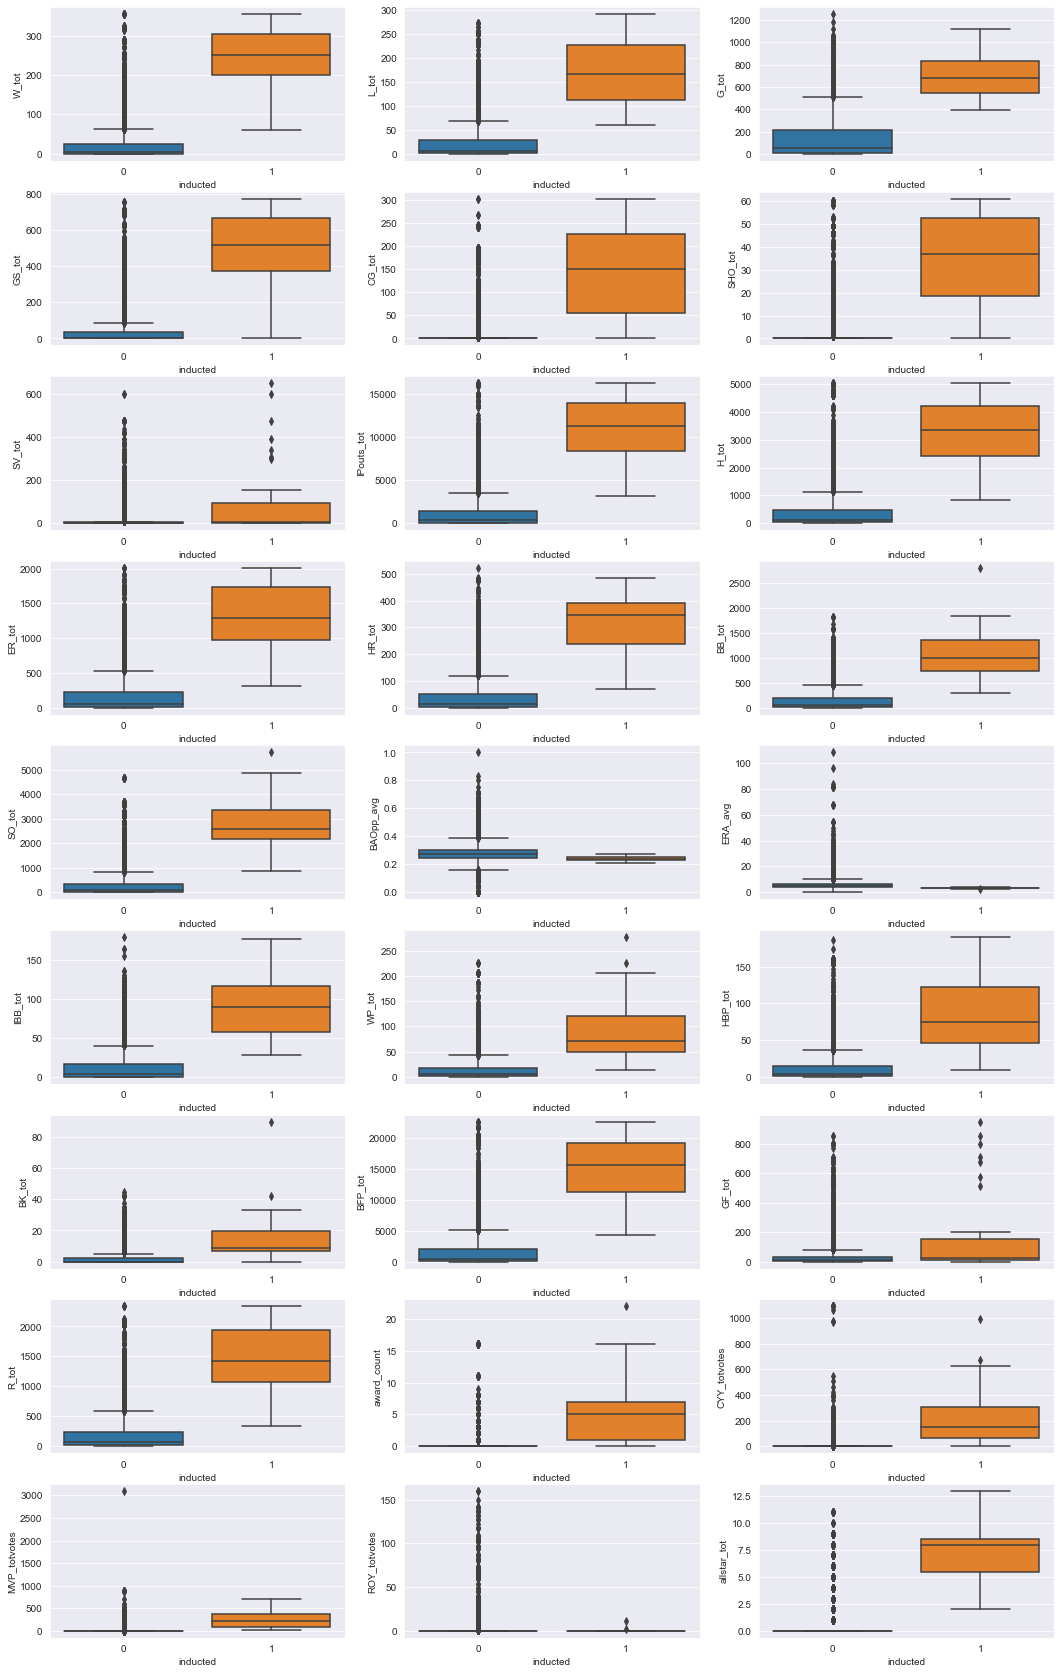

In [120]:
# Setting up box plots
sns.set_style("darkgrid")
fig, axes = plt.subplots(9, 3, figsize=(18, 30))

#fig.suptitle('Pokemon Stats by Generation')

for i, variable in enumerate(column_names):
    # print (i)
    row = i // 3 # integer divide i by 3 (how many times does 3 go into i (discard the fraction))
                 # ex. 16 // 3 = 5 1/3 (discard the 1/3) = 5
    # print(row)
    col = i % 3 # modulo divide i by 3 times and get remainder (3 goes into )
                # ex. 16 % 3 = 16 - (3 * 5 = 15) = 1   so (row, column) is (5,1)
    # print(col)
    sns.boxplot(ax=axes[row, col], data=Pitching_Career, x='inducted', y=variable)

# plt.tight_layout()
# plt.show()
    
#     sns.boxplot(ax=axes[0, x], data=Pitching_Career, x='inducted', y='W_tot')
#     sns.boxplot(ax=axes[0, x], data=Pitching_Career, x='inducted', y='L_tot')
#     sns.boxplot(ax=axes[0, x], data=Pitching_Career, x='inducted', y='G_tot')
#     sns.boxplot(ax=axes[1, x], data=Pitching_Career, x='inducted', y='GS_tot')
#     sns.boxplot(ax=axes[1, x], data=Pitching_Career, x='inducted', y='SHO_tot')
#     sns.boxplot(ax=axes[1, x], data=Pitching_Career, x='inducted', y='SV_tot')


<AxesSubplot:xlabel='award_count', ylabel='Count'>

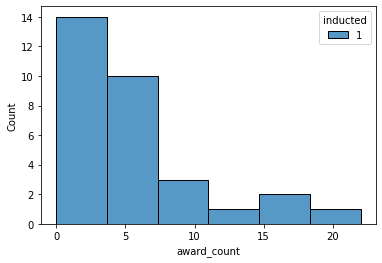

In [169]:
sns.histplot(data=Pitching_HOF_Career, x="award_count", hue="inducted", multiple="dodge")

## General information

In [38]:
# Pitching_df and hall of fame
q = '''
with p as
    (
    SELECT 
        playerID,
        MAX(yearID) as yearID
    FROM
        Pitching_df 
    GROUP BY playerID
    )
    
SELECT 
*
FROM
    p
INNER JOIN
    HallOfFame_df h
        on p.playerID = h.playerID
WHERE
h.inducted = 'Y'
AND p.yearID >= 1955
order by 2;
'''
joined = sqldf(q, locals())
print(len(joined))
joined

42


,playerID,yearID,playerID,yearID,votedBy,ballots,needed,votes,inducted,category,needed_note
0,newhoha01,1955,newhoha01,1992,Veterans,NaN,NaN,NaN,Y,Player,None
1,fellebo01,1956,fellebo01,1962,BBWAA,160.0,120.0,150.0,Y,Player,None
2,lasorto01,1956,lasorto01,1997,Veterans,NaN,NaN,NaN,Y,Manager,None
3,lemonbo01,1958,lemonbo01,1976,BBWAA,388.0,291.0,305.0,Y,Player,None
4,wynnea01,1963,wynnea01,1972,BBWAA,396.0,297.0,301.0,Y,Player,None
5,paigesa01,1965,paigesa01,1971,Negro League,NaN,NaN,NaN,Y,Player,None
6,spahnwa01,1965,spahnwa01,1973,BBWAA,380.0,285.0,316.0,Y,Player,None
7,koufasa01,1966,koufasa01,1972,BBWAA,396.0,297.0,344.0,Y,Player,None
8,roberro01,1966,roberro01,1976,BBWAA,388.0,291.0,337.0,Y,Player,None
9,fordwh01,1967,fordwh01,1974,BBWAA,365.0,274.0,284.0,Y,Player,None
